In [27]:
import pandas as pd

# Load the dataset if not already loaded
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Step 1: Categorize buildings by generation based on 'Year Built'
def categorize_generation(year_built):
    if pd.isna(year_built):
        return 'Unknown'
    elif year_built < 1960:
        return '1st Generation'
    elif 1960 <= year_built < 1980:
        return '2nd Generation'
    elif 1980 <= year_built < 2000:
        return '3rd Generation'
    elif year_built >= 2000:
        return '4th Generation (Grade A)'
    else:
        return 'Unknown'

# Apply the categorization
storage_data['Building Generation'] = storage_data['Year Built'].apply(categorize_generation)

# Step 2: Assign numerical scores to each building generation
def generation_score(generation):
    if generation == '1st Generation':
        return 1
    elif generation == '2nd Generation':
        return 2
    elif generation == '3rd Generation':
        return 3
    elif generation == '4th Generation (Grade A)':
        return 4
    else:
        return None

# Apply the scores to the Building Generation column
storage_data['Generation Score'] = storage_data['Building Generation'].apply(generation_score)

# Step 3: Convert 'Typical Floor Size' to numeric, handling any non-numeric values
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Step 4: Calculate the weighted average grade per Local Authority

def weighted_average(x):
    typical_floor_sum = x['Typical Floor Size'].sum()
    # Avoid division by zero or NaN by checking if sum is 0 or NaN
    if pd.isna(typical_floor_sum) or typical_floor_sum == 0:
        return pd.Series({'Weighted Average Grade': None})  # Return None if no valid data to calculate
    return pd.Series({
        'Weighted Average Grade': (x['Generation Score'] * x['Typical Floor Size']).sum() / typical_floor_sum
    })

# Perform the groupby operation, selecting only the relevant columns
weighted_avg_grade = storage_data.groupby('Local Authority ')[['Generation Score', 'Typical Floor Size']].apply(weighted_average).reset_index()

# Display the result
print(weighted_avg_grade)

        Local Authority   Weighted Average Grade
0          Aberdeen City                2.954198
1    Ards and North Down                1.249426
2                   Arun                1.000000
3                Ashford                1.309499
4         Aylesbury Vale                1.000000
..                   ...                     ...
226            Wokingham                2.952599
227        Wolverhampton                3.000000
228              Wycombe                2.845196
229          Wyre Forest                3.000000
230                 York                3.281959

[231 rows x 2 columns]


In [9]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import folium
import json

# Load the dataset
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Remove duplicates and clean data
storage_data = storage_data.drop_duplicates(subset=['Property Address'])
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Categorize year ranges
def categorize_year_built(year_built):
    if pd.isna(year_built):
        return 'Unknown'
    elif year_built < 1960:
        return 'Before 1960'
    elif 1960 <= year_built < 1980:
        return '1960-1980'
    elif 1980 <= year_built < 2000:
        return '1980-2000'
    elif year_built >= 2000:
        return '2000 and Later'
    else:
        return 'Unknown'

storage_data['Year Range'] = storage_data['Year Built'].apply(categorize_year_built)

# Aggregate data by Local Authority and Year Range
aggregated_space = storage_data.dropna(subset=['Typical Floor Size']).groupby(['Local Authority ', 'Year Range'])['Typical Floor Size'].sum().reset_index()

# Load GeoJSON data
with open('LAs.geojson') as f:
    geojson_data = json.load(f)

# Initialize the Dash app
app = dash.Dash(__name__)

# App layout with a dropdown for filtering year ranges
app.layout = html.Div([
    html.H1("Local Authorities Typical Floor Size Map"),
    dcc.Dropdown(
        id='year-range-filter',
        options=[{'label': year_range, 'value': year_range} for year_range in aggregated_space['Year Range'].unique()],
        value='2000 and Later',  # Default selection
        clearable=False,
        style={'width': '50%'}
    ),
    html.Iframe(id='map', srcDoc=None, width='100%', height='600')  # Placeholder for the map
])

# Callback to update the map based on selected year range
@app.callback(
    Output('map', 'srcDoc'),
    Input('year-range-filter', 'value')
)
def update_map(selected_year_range):
    # Filter the data based on the selected year range
    data_filtered = aggregated_space[aggregated_space['Year Range'] == selected_year_range]
    
    # Create a new Folium map
    m = folium.Map(location=[54.5, -3.0], zoom_start=6)
    
    # Add a choropleth layer based on the filtered data
    folium.Choropleth(
        geo_data=geojson_data,
        name=selected_year_range,
        data=data_filtered,
        columns=['Local Authority ', 'Typical Floor Size'],
        key_on="feature.properties.LAD21NM",
        fill_color="YlGnBu",
        fill_opacity=0.7,
        line_opacity=0.2,
        nan_fill_color="lightgrey",  # Grey out areas with no data
        nan_fill_opacity=0.4,
        legend_name=f"Typical Floor Size for {selected_year_range}"
    ).add_to(m)

    # Return the HTML representation of the Folium map to display in the Dash app
    return m._repr_html_()

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)

In [36]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import LinearColormap
from folium.features import GeoJsonTooltip

# Load the dataset
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Categorize buildings by generation based on 'Year Built' if not already categorized
def categorize_generation(year_built):
    if pd.isna(year_built):
        return 'Unknown'
    elif year_built < 1960:
        return '1st Generation'
    elif 1960 <= year_built < 1980:
        return '2nd Generation'
    elif 1980 <= year_built < 2000:
        return '3rd Generation'
    elif year_built >= 2000:
        return '4th Generation (Grade A)'
    else:
        return 'Unknown'

# Apply the categorization to create the 'Building Generation' column if it doesn't exist
if 'Building Generation' not in storage_data.columns:
    storage_data['Building Generation'] = storage_data['Year Built'].apply(categorize_generation)

# Ensure 'Generation Score' is calculated based on the 'Building Generation' column
def generation_score(generation):
    score_dict = {
        '1st Generation': 1,
        '2nd Generation': 2,
        '3rd Generation': 3,
        '4th Generation (Grade A)': 4
    }
    return score_dict.get(generation, None)

# Apply the Generation Score to the 'Building Generation' column
storage_data['Generation Score'] = storage_data['Building Generation'].apply(generation_score)

# Convert 'Typical Floor Size' to numeric, handling any non-numeric values
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Calculate the weighted average grade per Local Authority without including grouping columns
def weighted_average(x):
    typical_floor_sum = x['Typical Floor Size'].sum()
    if pd.isna(typical_floor_sum) or typical_floor_sum == 0:
        return pd.Series({'Weighted Average Grade': None})
    return pd.Series({
        'Weighted Average Grade': (x['Generation Score'] * x['Typical Floor Size']).sum() / typical_floor_sum
    })

# Group by Local Authority and apply the weighted average calculation
# Explicitly select the relevant columns to exclude the grouping column
grouped = storage_data.groupby('Local Authority ', as_index=False)
weighted_avg_grade = grouped[['Generation Score', 'Typical Floor Size']].apply(weighted_average)

# Calculate the number of fourth-generation (Grade A) buildings
fourth_gen_count = storage_data[storage_data['Building Generation'] == '4th Generation (Grade A)'] \
    .groupby('Local Authority ').size().reset_index(name='Fourth Gen Count')

# Merge results into the weighted_avg_grade DataFrame
weighted_avg_grade = weighted_avg_grade.merge(fourth_gen_count, on='Local Authority ', how='left')

# Load the GeoJSON file with Local Authority boundaries as a GeoDataFrame
gdf = gpd.read_file('LAs.geojson')

# Clean and standardize the LAD21NM column in the GeoDataFrame
gdf['LAD21NM'] = gdf['LAD21NM'].str.strip().str.lower()

# Clean and standardize the Local Authority column in the weighted_avg_grade DataFrame
weighted_avg_grade['Local Authority '] = weighted_avg_grade['Local Authority '].str.strip().str.lower()

# Merge the GeoDataFrame with the weighted average grade data
gdf = gdf.merge(weighted_avg_grade, left_on='LAD21NM', right_on='Local Authority ', how='left')

# Validate and set min/max values for colormap
valid_grades = gdf['Weighted Average Grade'].dropna()
min_value, max_value = (valid_grades.min(), valid_grades.max()) if not valid_grades.empty else (0, 4)

# Ensure thresholds are sorted correctly
min_value, max_value = sorted([min_value, max_value])

# Create a LinearColormap using the YlGnBu color scheme
colormap = LinearColormap(
    colors=['#ffffd9', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84'],
    vmin=min_value,
    vmax=max_value,
    caption='Weighted Average Building Grade'
)

# Convert the GeoDataFrame to GeoJSON format for Folium
gdf_json = gdf.to_json()

# Create a base map centered on the UK
m = folium.Map(location=[54.0, -2.0], zoom_start=6, tiles='cartodbpositron')

# Add the GeoJSON layer to the map with custom styling using the color scale
folium.GeoJson(
    gdf_json,
    name="Local Authorities",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties'].get('Weighted Average Grade')) if feature['properties'].get('Weighted Average Grade') is not None else 'lightgrey',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(
        fields=['LAD21NM', 'Weighted Average Grade', 'Fourth Gen Count'],
        aliases=['Local Authority:', 'Weighted Avg Grade:', 'Number of 4th Gen Buildings:'],
        localize=True,
        sticky=True
    )
).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Save the map as an HTML file
m.save("grade_map.html")

print("Map saved as 'grade_map.html'")

Map saved as 'grade_map.html'


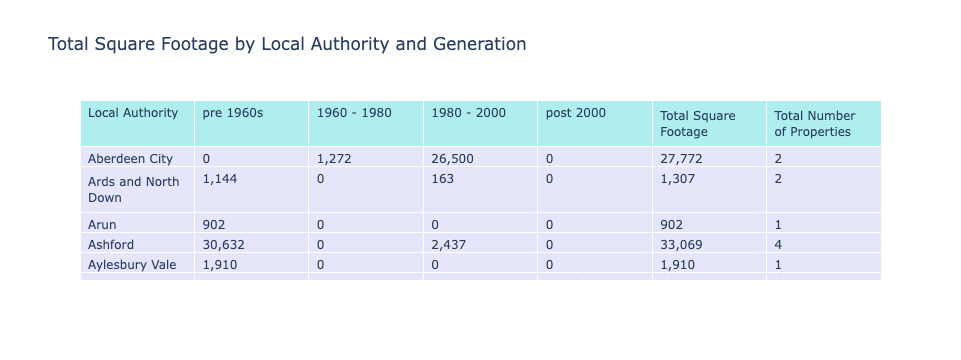

In [47]:
import pandas as pd
import plotly.graph_objects as go

# Load the dataset
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Remove duplicates based on relevant columns (e.g., Property Address or other unique identifier)
# Adjust columns used for checking duplicates based on your dataset specifics
storage_data = storage_data.drop_duplicates(subset=['Property Address'])

# Define a function to categorize buildings by generation based on 'Year Built'
def categorize_generation(year_built):
    if pd.isna(year_built):
        return 'pre 1960s'
    elif year_built < 1960:
        return 'pre 1960s'
    elif 1960 <= year_built < 1980:
        return '1960 - 1980'
    elif 1980 <= year_built < 2000:
        return '1980 - 2000'
    elif year_built >= 2000:
        return 'post 2000'
    else:
        return 'Unknown'

# Apply the categorization to create the 'Building Generation' column if it doesn't exist
if 'Building Generation' not in storage_data.columns:
    storage_data['Building Generation'] = storage_data['Year Built'].apply(categorize_generation)

# Convert 'Typical Floor Size' to numeric, handling any non-numeric values
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Aggregate total square footage per local authority by generation
total_sqft_by_generation = storage_data.groupby(['Local Authority ', 'Building Generation'])['Typical Floor Size'].sum().reset_index()

# Count the number of properties per local authority
property_count = storage_data.groupby('Local Authority ').size().reset_index(name='Total Number of Properties')

# Pivot the data to have generations as columns
pivot_table = total_sqft_by_generation.pivot(index='Local Authority ', columns='Building Generation', values='Typical Floor Size').fillna(0)

# Merge with property count data to include the total number of properties
pivot_table = pivot_table.merge(property_count, on='Local Authority ', how='left')

# Calculate the total square footage for each local authority
pivot_table['Total Square Footage'] = pivot_table[['pre 1960s', '1960 - 1980', '1980 - 2000', 'post 2000']].sum(axis=1)

# Calculate the overall totals for square footage and number of properties
total_sqft = pivot_table['Total Square Footage'].sum()  # Sum of total square footage
total_properties = pivot_table['Total Number of Properties'].sum()  # Sum of total properties

# Create a summary row with total values
summary_row = pd.DataFrame({
    'pre 1960s': [pivot_table['pre 1960s'].sum()],
    '1960 - 1980': [pivot_table['1960 - 1980'].sum()],
    '1980 - 2000': [pivot_table['1980 - 2000'].sum()],
    'post 2000': [pivot_table['post 2000'].sum()],
    'Total Square Footage': [total_sqft],
    'Total Number of Properties': [total_properties]
}, index=['Total'])

# Append the summary row to the pivot table
pivot_table = pd.concat([pivot_table, summary_row])

# Ensure the Local Authority column displays names, not numbers (assuming it's due to formatting or index issues)
pivot_table.reset_index(inplace=True)
pivot_table.loc[pivot_table['Local Authority '].isnull(), 'Local Authority '] = 'Total'  # Explicitly label the summary row

# Convert the table to a Plotly figure with formatted cells
fig = go.Figure(data=[go.Table(
    header=dict(values=['Local Authority', 'pre 1960s', '1960 - 1980', '1980 - 2000', 'post 2000', 'Total Square Footage', 'Total Number of Properties'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[pivot_table['Local Authority '],
                       pivot_table['pre 1960s'].map('{:,.0f}'.format),
                       pivot_table['1960 - 1980'].map('{:,.0f}'.format),
                       pivot_table['1980 - 2000'].map('{:,.0f}'.format),
                       pivot_table['post 2000'].map('{:,.0f}'.format),
                       pivot_table['Total Square Footage'].map('{:,.0f}'.format),
                       pivot_table['Total Number of Properties']],
               fill_color='lavender',
               align='left'))
])

# Update layout
fig.update_layout(title='Total Square Footage by Local Authority and Generation')

# Show the table
fig.show()

In [48]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import LinearColormap
from folium.features import GeoJsonTooltip

# Load the dataset
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Remove duplicates based on relevant columns (e.g., Property Address or other unique identifier)
storage_data = storage_data.drop_duplicates(subset=['Property Address'])

# Define a function to categorize buildings by generation based on 'Year Built'
def categorize_generation(year_built):
    if pd.isna(year_built):
        return 'Unknown'
    elif year_built < 1960:
        return 'pre 1960s'
    elif 1960 <= year_built < 1980:
        return '1960 - 1980'
    elif 1980 <= year_built < 2000:
        return '1980 - 2000'
    elif year_built >= 2000:
        return '4th Generation (Grade A)'
    else:
        return 'Unknown'

# Apply the categorization to create the 'Building Generation' column
storage_data['Building Generation'] = storage_data['Year Built'].apply(categorize_generation)

# Convert 'Typical Floor Size' to numeric, handling any non-numeric values
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Calculate total square footage per local authority
total_sqft = storage_data.groupby('Local Authority ')['Typical Floor Size'].sum().reset_index(name='Total Sq Ft')

# Calculate the number of properties built after 2000 (4th Generation)
fourth_gen_count = storage_data[storage_data['Building Generation'] == '4th Generation (Grade A)'] \
    .groupby('Local Authority ').size().reset_index(name='Fourth Gen Count')

# Calculate the total number of properties per local authority
total_properties = storage_data.groupby('Local Authority ').size().reset_index(name='Total Properties')

# Merge total properties and fourth generation counts
merged_data = total_properties.merge(fourth_gen_count, on='Local Authority ', how='left').fillna(0)

# Calculate the percentage of properties built after 2000
merged_data['% Built After 2000'] = (merged_data['Fourth Gen Count'] / merged_data['Total Properties']) * 100

# Merge total square footage with the percentage data
final_data = total_sqft.merge(merged_data[['Local Authority ', '% Built After 2000']], on='Local Authority ', how='left')

# Load the GeoJSON file with Local Authority boundaries as a GeoDataFrame
gdf = gpd.read_file('LAs.geojson')

# Clean and standardize the LAD21NM column in the GeoDataFrame
gdf['LAD21NM'] = gdf['LAD21NM'].str.strip().str.lower()

# Clean and standardize the Local Authority column in the final data DataFrame
final_data['Local Authority '] = final_data['Local Authority '].str.strip().str.lower()

# Merge the GeoDataFrame with the final data
gdf = gdf.merge(final_data, left_on='LAD21NM', right_on='Local Authority ', how='left')

# Set min and max values for colormap
valid_grades = gdf['Total Sq Ft'].dropna()
min_value, max_value = (valid_grades.min(), valid_grades.max()) if not valid_grades.empty else (0, 4)

# Create a LinearColormap using the YlGnBu color scheme
colormap = LinearColormap(
    colors=['#ffffd9', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84'],
    vmin=min_value,
    vmax=max_value,
    caption='Total Square Footage'
)

# Convert the GeoDataFrame to GeoJSON format for Folium
gdf_json = gdf.to_json()

# Create a base map centered on the UK
m = folium.Map(location=[54.0, -2.0], zoom_start=6, tiles='cartodbpositron')

# Add the GeoJSON layer to the map with custom styling using the color scale
folium.GeoJson(
    gdf_json,
    name="Local Authorities",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties'].get('Total Sq Ft')) if feature['properties'].get('Total Sq Ft') is not None else 'lightgrey',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(
        fields=['LAD21NM', 'Total Sq Ft', '% Built After 2000'],
        aliases=['Local Authority:', 'Total Square Footage:', '% Built After 2000:'],
        localize=True,
        sticky=True
    )
).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Save the map as an HTML file
m.save("weighted_avg_building_grade_map_with_tooltips.html")

print("Map saved as 'weighted_avg_building_grade_map_with_tooltips.html'")

Map saved as 'weighted_avg_building_grade_map_with_tooltips.html'


In [50]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import LinearColormap
from folium.features import GeoJsonTooltip

# Load the dataset
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Remove duplicates based on relevant columns (e.g., Property Address or other unique identifier)
storage_data = storage_data.drop_duplicates(subset=['Property Address'])

# Define a function to categorize buildings by generation based on 'Year Built'
def categorize_generation(year_built):
    if pd.isna(year_built):
        return 'Unknown'
    elif year_built < 1960:
        return 'pre 1960s'
    elif 1960 <= year_built < 1980:
        return '1960 - 1980'
    elif 1980 <= year_built < 2000:
        return '1980 - 2000'
    elif year_built >= 2000:
        return '4th Generation (Grade A)'
    else:
        return 'Unknown'

# Apply the categorization to create the 'Building Generation' column
storage_data['Building Generation'] = storage_data['Year Built'].apply(categorize_generation)

# Assign numerical scores to each building generation
def generation_score(generation):
    score_dict = {
        'pre 1960s': 1,
        '1960 - 1980': 2,
        '1980 - 2000': 3,
        '4th Generation (Grade A)': 4
    }
    return score_dict.get(generation, None)

# Apply the Generation Score to the 'Building Generation' column
storage_data['Generation Score'] = storage_data['Building Generation'].apply(generation_score)

# Convert 'Typical Floor Size' to numeric, handling any non-numeric values
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Calculate the weighted average grade per Local Authority
def weighted_average(x):
    typical_floor_sum = x['Typical Floor Size'].sum()
    if pd.isna(typical_floor_sum) or typical_floor_sum == 0:
        return pd.Series({'Weighted Average Grade': None})
    return pd.Series({
        'Weighted Average Grade': (x['Generation Score'] * x['Typical Floor Size']).sum() / typical_floor_sum
    })

# Group by Local Authority and apply the weighted average calculation
grouped = storage_data.groupby('Local Authority ', as_index=False)
weighted_avg_grade = grouped[['Generation Score', 'Typical Floor Size']].apply(weighted_average)

# Calculate total square footage per local authority
total_sqft = storage_data.groupby('Local Authority ')['Typical Floor Size'].sum().reset_index(name='Total Sq Ft')

# Calculate the number of properties built after 2000 (4th Generation)
fourth_gen_count = storage_data[storage_data['Building Generation'] == '4th Generation (Grade A)'] \
    .groupby('Local Authority ').size().reset_index(name='Fourth Gen Count')

# Calculate the total number of properties per local authority
total_properties = storage_data.groupby('Local Authority ').size().reset_index(name='Total Properties')

# Merge total properties and fourth generation counts
merged_data = total_properties.merge(fourth_gen_count, on='Local Authority ', how='left').fillna(0)

# Calculate the percentage of properties built after 2000
merged_data['% Built After 2000'] = (merged_data['Fourth Gen Count'] / merged_data['Total Properties']) * 100

# Merge weighted average grade, total square footage, and percentage data
final_data = weighted_avg_grade.merge(total_sqft, on='Local Authority ', how='left')
final_data = final_data.merge(merged_data[['Local Authority ', '% Built After 2000']], on='Local Authority ', how='left')

# Load the GeoJSON file with Local Authority boundaries as a GeoDataFrame
gdf = gpd.read_file('LAs.geojson')

# Clean and standardize the LAD21NM column in the GeoDataFrame
gdf['LAD21NM'] = gdf['LAD21NM'].str.strip().str.lower()

# Clean and standardize the Local Authority column in the final data DataFrame
final_data['Local Authority '] = final_data['Local Authority '].str.strip().str.lower()

# Merge the GeoDataFrame with the final data
gdf = gdf.merge(final_data, left_on='LAD21NM', right_on='Local Authority ', how='left')

# Set min and max values for colormap based on Weighted Average Grade
valid_grades = gdf['Weighted Average Grade'].dropna()
min_value, max_value = (valid_grades.min(), valid_grades.max()) if not valid_grades.empty else (0, 4)

# Create a LinearColormap using the YlGnBu color scheme
colormap = LinearColormap(
    colors=['#ffffd9', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84'],
    vmin=min_value,
    vmax=max_value,
    caption='Weighted Average Building Grade'
)

# Convert the GeoDataFrame to GeoJSON format for Folium
gdf_json = gdf.to_json()

# Create a base map centered on the UK
m = folium.Map(location=[54.0, -2.0], zoom_start=6, tiles='cartodbpositron')

# Add the GeoJSON layer to the map with custom styling using the color scale
folium.GeoJson(
    gdf_json,
    name="Local Authorities",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties'].get('Weighted Average Grade')) if feature['properties'].get('Weighted Average Grade') is not None else 'lightgrey',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(
        fields=['LAD21NM', 'Weighted Average Grade', 'Total Sq Ft', '% Built After 2000'],
        aliases=['Local Authority:', 'Weighted Avg Grade:', 'Total Square Footage:', '% Built After 2000:'],
        localize=True,
        sticky=True
    )
).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

# Save the map as an HTML file
m.save("weighted_avg_building_grade_map_with_tooltips.html")

print("Map saved as 'weighted_avg_building_grade_map_with_tooltips.html'")

Map saved as 'weighted_avg_building_grade_map_with_tooltips.html'


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium.plugins import FloatImage
from branca.colormap import LinearColormap
from folium.features import GeoJsonTooltip
import plotly.graph_objects as go
from dash import Dash, dcc, html

# Load the dataset
storage_data = pd.read_csv('merged_self_storage_with_lAs.csv')

# Remove duplicates based on relevant columns (e.g., Property Address or other unique identifier)
storage_data = storage_data.drop_duplicates(subset=['Property Address'])

# Define a function to categorize buildings by generation based on 'Year Built'
def categorize_generation(year_built):
    if pd.isna(year_built):
        return 'Unknown'
    elif year_built < 1960:
        return 'pre 1960s'
    elif 1960 <= year_built < 1980:
        return '1960 - 1980'
    elif 1980 <= year_built < 2000:
        return '1980 - 2000'
    elif year_built >= 2000:
        return 'post 2000'
    else:
        return 'Unknown'

# Apply the categorization to create the 'Building Generation' column
storage_data['Building Generation'] = storage_data['Year Built'].apply(categorize_generation)

# Convert 'Typical Floor Size' to numeric, handling any non-numeric values
storage_data['Typical Floor Size'] = pd.to_numeric(storage_data['Typical Floor Size'], errors='coerce')

# Aggregate total square footage per local authority by generation
total_sqft_by_generation = storage_data.groupby(['Local Authority ', 'Building Generation'])['Typical Floor Size'].sum().reset_index()

# Count the number of properties per local authority
property_count = storage_data.groupby('Local Authority ').size().reset_index(name='Total Number of Properties')

# Pivot the data to have generations as columns
pivot_table = total_sqft_by_generation.pivot(index='Local Authority ', columns='Building Generation', values='Typical Floor Size').fillna(0)

# Merge with property count data to include the total number of properties
pivot_table = pivot_table.merge(property_count, on='Local Authority ', how='left')

# Calculate the total square footage for each local authority
pivot_table['Total Square Footage'] = pivot_table[['pre 1960s', '1960 - 1980', '1980 - 2000', 'post 2000']].sum(axis=1)

# Calculate the overall totals for square footage and number of properties
total_sqft = pivot_table['Total Square Footage'].sum()  
total_properties = pivot_table['Total Number of Properties'].sum()

# Create a summary row with total values
summary_row = pd.DataFrame({
    'pre 1960s': [pivot_table['pre 1960s'].sum()],
    '1960 - 1980': [pivot_table['1960 - 1980'].sum()],
    '1980 - 2000': [pivot_table['1980 - 2000'].sum()],
    'post 2000': [pivot_table['post 2000'].sum()],
    'Total Square Footage': [total_sqft],
    'Total Number of Properties': [total_properties]
}, index=['Total'])

# Append the summary row to the pivot table
pivot_table = pd.concat([pivot_table, summary_row])

# Reset index to prepare for plotting
pivot_table.reset_index(inplace=True)
pivot_table.loc[pivot_table['Local Authority '].isnull(), 'Local Authority '] = 'Total' 

# Assign pivot_table to table_df for the table visualization
table_df = pivot_table.copy()

# Step 1: Create the Table Image
def create_table_image(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.savefig('table_image.png', bbox_inches='tight', pad_inches=0.1, dpi=150)
    plt.close()

# Create and save the table image
create_table_image(table_df)

# Step 2: Create the Map and Overlay the Table Image
# Load the GeoJSON file with Local Authority boundaries as a GeoDataFrame
gdf = gpd.read_file('LAs.geojson')

# Create a base map centered on the UK
m = folium.Map(location=[54.0, -2.0], zoom_start=6, tiles='cartodbpositron')

# Add the overlay of the table image on the map
FloatImage('table_image.png', bottom=5, left=75).add_to(m)

# Save the map as an HTML file with the table overlay
m.save("combined_map_with_table.html")
print("Map saved with table overlay as 'combined_map_with_table.html'")

# Step 3: Optional - Dash Integration for Full Interactivity
app = Dash(__name__)

# Convert the table to a Plotly figure for Dash
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Local Authority', 'pre 1960s', '1960 - 1980', '1980 - 2000', 'post 2000', 'Total Square Footage', 'Total Number of Properties'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[table_df['Local Authority '],
                       table_df['pre 1960s'].map('{:,.0f}'.format),
                       table_df['1960 - 1980'].map('{:,.0f}'.format),
                       table_df['1980 - 2000'].map('{:,.0f}'.format),
                       table_df['post 2000'].map('{:,.0f}'.format),
                       table_df['Total Square Footage'].map('{:,.0f}'.format),
                       table_df['Total Number of Properties']],
               fill_color='lavender',
               align='left'))
])

# Define layout of the Dash app with the map and table
app.layout = html.Div([
    html.H1("Self Storage "),
    html.Div([
        dcc.Graph(figure=table_fig, style={'width': '50%', 'display': 'inline-block'}),
        html.Iframe(srcDoc=open('weighted_avg_building_grade_map_with_tooltips.html', 'r').read(),
                    width='50%', height='600', style={'display': 'inline-block'}),
    ])
])

# Uncomment below line if you wish to run the Dash app separately
app.run_server(debug=True)
# http://127.0.0.1:8050

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Map saved with table overlay as 'combined_map_with_table.html'
